In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

In [2]:

################# Parameters #####################

path = "myData"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 400
epochs_val = 25
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation


In [3]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [39]:
############################### Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [40]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[
    0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0] == y_validation.shape[
    0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:] == (imageDimesions)), " The dimesions of the Training images are wrong "
assert (X_validation.shape[1:] == (imageDimesions)), " The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:] == (imageDimesions)), " The dimesionas of the Test images are wrong"


Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [41]:
############################### READ CSV FILE
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


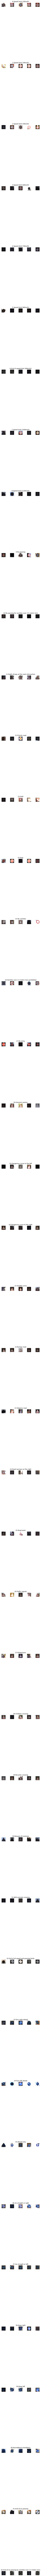

In [42]:

############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))


[115, 1298, 1258, 799, 1114, 1046, 231, 846, 792, 818, 1156, 736, 1220, 1218, 436, 339, 232, 621, 709, 114, 202, 171, 200, 277, 150, 870, 347, 134, 304, 160, 244, 432, 143, 403, 232, 717, 219, 117, 1196, 185, 194, 141, 135]


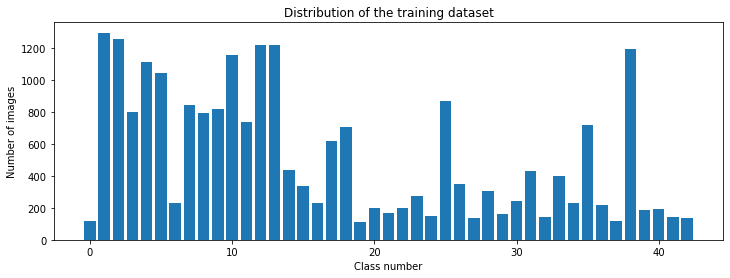

In [43]:

############################### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


In [44]:
############################### PREPROCESSING THE IMAGES

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img



In [45]:

X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
cv2.imshow("GrayScale Images",
           X_train[random.randint(0, len(X_train) - 1)])  # TO CHECK IF THE TRAINING IS DONE PROPERLY

In [46]:

############################### ADD A DEPTH OF 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


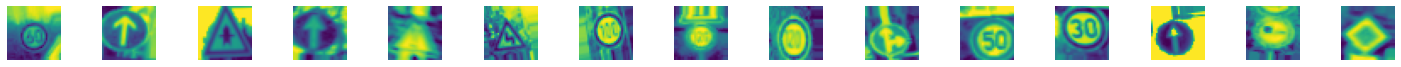

In [47]:
############################### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,
                       batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)


In [48]:
imageDimesions[0]

32

In [49]:
60//2


30

In [50]:
############################### CONVOLUTION NEURAL NETWORK MODEL
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
 

In [51]:
 
############################### TRAIN
model = myModel()

history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)
 

Epoch 1/25
400/400 [==============================] - 7s 14ms/step - loss: 2.5916 - accuracy: 0.2779 - val_loss: 0.9796 - val_accuracy: 0.7188
Epoch 2/25
400/400 [==============================] - 6s 16ms/step - loss: 1.3394 - accuracy: 0.5845 - val_loss: 0.4314 - val_accuracy: 0.8772
Epoch 3/25
400/400 [==============================] - 6s 16ms/step - loss: 0.9254 - accuracy: 0.7117 - val_loss: 0.2447 - val_accuracy: 0.9325
Epoch 4/25
400/400 [==============================] - 6s 14ms/step - loss: 0.6922 - accuracy: 0.7832 - val_loss: 0.1348 - val_accuracy: 0.9632
Epoch 5/25
400/400 [==============================] - 5s 14ms/step - loss: 0.5752 - accuracy: 0.8188 - val_loss: 0.1067 - val_accuracy: 0.9740
Epoch 6/25
400/400 [==============================] - 5s 13ms/step - loss: 0.4917 - accuracy: 0.8466 - val_loss: 0.0900 - val_accuracy: 0.9725
Epoch 7/25
400/400 [==============================] - 6s 15ms/step - loss: 0.4305 - accuracy: 0.8640 - val_loss: 0.0737 - val_accuracy: 0.9793

In [52]:
print(history.model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, None, None, 60)    1560      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, None, None, 60)    90060     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, None, None, 60)    0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, None, None, 30)    16230     
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, None, None, 30)    8130      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, None, None, 30)    0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, None, None, 30)   

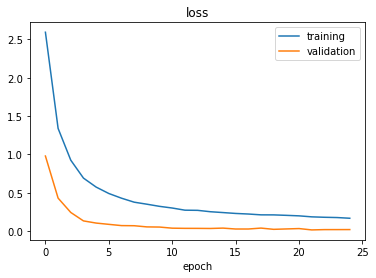

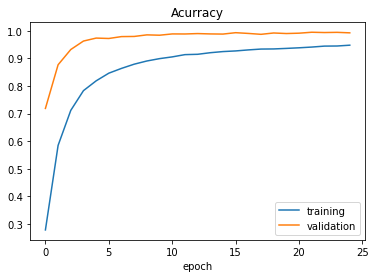

Test Score: 0.02772950753569603
Test Accuracy: 0.9925287365913391


In [53]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])


In [54]:
#############################################
 
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75         # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX
##############################################

In [55]:
# SETUP THE VIDEO CAMERA
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)

False

In [56]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
def getCalssName(classNo):
    if   classNo == 0: return 'Speed Limit 20 km/h'
    elif classNo == 1: return 'Speed Limit 30 km/h'
    elif classNo == 2: return 'Speed Limit 50 km/h'
    elif classNo == 3: return 'Speed Limit 60 km/h'
    elif classNo == 4: return 'Speed Limit 70 km/h'
    elif classNo == 5: return 'Speed Limit 80 km/h'
    elif classNo == 6: return 'End of Speed Limit 80 km/h'
    elif classNo == 7: return 'Speed Limit 100 km/h'
    elif classNo == 8: return 'Speed Limit 120 km/h'
    elif classNo == 9: return 'No passing'
    elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
    elif classNo == 11: return 'Right-of-way at the next intersection'
    elif classNo == 12: return 'Priority road'
    elif classNo == 13: return 'Yield'
    elif classNo == 14: return 'Stop'
    elif classNo == 15: return 'No vechiles'
    elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
    elif classNo == 17: return 'No entry'
    elif classNo == 18: return 'General caution'
    elif classNo == 19: return 'Dangerous curve to the left'
    elif classNo == 20: return 'Dangerous curve to the right'
    elif classNo == 21: return 'Double curve'
    elif classNo == 22: return 'Bumpy road'
    elif classNo == 23: return 'Slippery road'
    elif classNo == 24: return 'Road narrows on the right'
    elif classNo == 25: return 'Road work'
    elif classNo == 26: return 'Traffic signals'
    elif classNo == 27: return 'Pedestrians'
    elif classNo == 28: return 'Children crossing'
    elif classNo == 29: return 'Bicycles crossing'
    elif classNo == 30: return 'Beware of ice/snow'
    elif classNo == 31: return 'Wild animals crossing'
    elif classNo == 32: return 'End of all speed and passing limits'
    elif classNo == 33: return 'Turn right ahead'
    elif classNo == 34: return 'Turn left ahead'
    elif classNo == 35: return 'Ahead only'
    elif classNo == 36: return 'Go straight or right'
    elif classNo == 37: return 'Go straight or left'
    elif classNo == 38: return 'Keep right'
    elif classNo == 39: return 'Keep left'
    elif classNo == 40: return 'Roundabout mandatory'
    elif classNo == 41: return 'End of no passing'
    elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'
    

In [ ]:
while True:
 
    # READ IMAGE
    success, imgOrignal = cap.read()
     
    # PROCESS IMAGE
    img = np.asarray(imgOrignal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    cv2.imshow("Processed Image", img)
    img = img.reshape(1, 32, 32, 1)
    cv2.putText(imgOrignal, "CLASS: " , (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    # PREDICT IMAGE
    predictions = model.predict(img)
    classIndex = model.predict_classes(img)
    probabilityValue =np.amax(predictions)
    if probabilityValue > threshold:
        #print(getCalssName(classIndex))
        cv2.putText(imgOrignal,str(classIndex)+" "+str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)
     
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break